В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
raw_df = pd.read_csv('/content/train.csv')

In [ ]:
raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [4]:
# Визначаємо назву цільової змінної
target_col = 'Exited'

# Розділяємо дані на тренувальні та валідаційні
train_df, val_df = split_train_val(raw_df, target_col)

# Визначаємо список ознак
input_cols = [col for col in raw_df.columns if col != target_col]

# Розділяємо ознаки та цільові змінні
X_train, y_train = separate_inputs_targets(train_df, input_cols, target_col)
X_val, y_val = separate_inputs_targets(val_df, input_cols, target_col)

X_train.shape, y_train.shape, X_val.shape, y_val.shape


((12000, 13), (12000,), (3000, 13), (3000,))

Ми зчитали дані train.csv в змінну raw_df, розділили на тренувальний та валідаційний набори 80/20:


Тренувальний набір містить:
12 000 екземплярів, 13 ознак


Цільова змінна містить 12 000 значень, які є мітками для кожного екземляра.


Валідаційний набір:

3 000 екземплярів, 13 ознак


Цільова змінна містить 3 000 значень, які є мітками для валідації.

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [5]:
# Перетворюємо категоріальні ознаки на тип category
categorical_cols = X_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_train[col] = pd.Categorical(X_train[col])
    X_val[col] = pd.Categorical(X_val[col])



In [6]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 6490 to 3024
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               3000 non-null   int64   
 1   CustomerId       3000 non-null   float64 
 2   Surname          3000 non-null   category
 3   CreditScore      3000 non-null   float64 
 4   Geography        3000 non-null   category
 5   Gender           3000 non-null   category
 6   Age              3000 non-null   float64 
 7   Tenure           3000 non-null   float64 
 8   Balance          3000 non-null   float64 
 9   NumOfProducts    3000 non-null   float64 
 10  HasCrCard        3000 non-null   float64 
 11  IsActiveMember   3000 non-null   float64 
 12  EstimatedSalary  3000 non-null   float64 
dtypes: category(3), float64(9), int64(1)
memory usage: 290.1 KB


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [8]:
xgb_model = XGBClassifier(
    max_depth=3,
    n_estimators=50,
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
    random_state=42
)

xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:46:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:46:38] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:46:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
# Оцінюємо точність моделі за AUROC
train_preds = xgb_model.predict_proba(X_train)[:, 1]
val_preds = xgb_model.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)

print(f'Train AUROC: {train_auc:.4f}')
print(f'Validation AUROC: {val_auc:.4f}')


Train AUROC: 0.9656
Validation AUROC: 0.9323


Обробка пропущених значень та категоріальних змінних з параметром missing=np.nan та enable_categorical=True дозволила моделі правильно працювати з даними, без необхідності їх попередньої обробки вручну.


Модель показує досить високу точність на тренувальних даних (AUROC = 0.9656), що свідчить про її здатність добре налаштовуватися на ці дані. Оскільки точність на валідаційних даних незначно знижена (AUROC = 0.9323), це вказує на хорошу здатність моделі узагальнювати і ефективно працювати з новими даними.


Модель XGBoost демонструє значно кращі результати порівняно з DecisionTree. Вона показує високу точність і на тренувальних, і на валідаційних даних. Модель добре працює з даними, має низький bias та variance.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [ ]:
!pip install hyperopt

In [10]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [16]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
    )

    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = clf.predict_proba(X_val)[:, 1]
    auroc = roc_auc_score(y_val, y_pred)

    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.2),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}


# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:02<00:52,  2.74s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:22] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:22] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:03<00:27,  1.52s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:04<00:20,  1.23s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:05<00:20,  1.30s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:08<00:26,  1.79s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:10<00:26,  1.90s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:12<00:24,  1.92s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:15<00:27,  2.28s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:16<00:19,  1.81s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:17<00:17,  1.74s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:20<00:18,  2.08s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:21<00:13,  1.70s/trial, best loss: -0.9341669524658756]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 13/20 [00:22<00:09,  1.41s/trial, best loss: -0.9370032238150764]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 14/20 [00:27<00:16,  2.67s/trial, best loss: -0.9370032238150764]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:29<00:12,  2.46s/trial, best loss: -0.9370032238150764]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 16/20 [00:30<00:08,  2.02s/trial, best loss: -0.9370032238150764]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:32<00:06,  2.04s/trial, best loss: -0.9370032238150764]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 18/20 [00:34<00:03,  1.93s/trial, best loss: -0.9370032238150764]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:36<00:01,  1.92s/trial, best loss: -0.9370032238150764]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:38<00:00,  1.91s/trial, best loss: -0.9370032238150764]
Найкращі гіперпараметри:  {'colsample_bytree': 0.5717941646149887, 'gamma': 0.28588128598392654, 'learning_rate': 0.025030332403369764, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 90, 'reg_alpha': 0.9595286087693452, 'reg_lambda': 0.4244607792511723, 'subsample': 0.6210988317075918}


In [18]:
best

{'colsample_bytree': 0.5717941646149887,
 'gamma': 0.28588128598392654,
 'learning_rate': 0.025030332403369764,
 'max_depth': 8,
 'min_child_weight': 6,
 'n_estimators': 90,
 'reg_alpha': 0.9595286087693452,
 'reg_lambda': 0.4244607792511723,
 'subsample': 0.6210988317075918}

In [17]:
# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
    random_state=42

)

final_clf.fit(X_train, y_train)

# Оцінка якості фінальної моделі
final_train_preds = final_clf.predict_proba(X_train)[:, 1]
final_val_preds = final_clf.predict_proba(X_val)[:, 1]

final_train_auc = roc_auc_score(y_train, final_train_preds)
final_val_auc = roc_auc_score(y_val, final_val_preds)

print(f'Final Train AUROC: {final_train_auc:.4f}')
print(f'Final Validation AUROC: {final_val_auc:.4f}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:52:10] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:52:10] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:52:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Train AUROC: 0.9524
Final Validation AUROC: 0.9363


Оцінка точності моделі:

Train AUROC: 0.9524 — Модель демонструє високу точність на тренувальному наборі, що свідчить про її здатність добре адаптуватися до навчальних даних.


Validation AUROC: 0.9363 — Точність на валідаційному наборі також висока, хоча трохи менша, ніж на тренувальних даних. Це свідчить про те, що модель добре узагальнює і не схильна до перенавчання.


Висновок:

Порівняно з попереднім пунктом, де ми отримали AUROC на тренувальних даних 0.9656 та на валідаційних — 0.9323, точність на тренувальних даних трохи знизилась, тоді як на валідаційних підвищилась. Це призвело до зменшення різниці між результатами на тренувальних і валідаційних даних, що вказує на поліпшення стабільності моделі.

In [19]:
test_df = pd.read_csv('/content/test.csv')

In [20]:
categorical_cols = test_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    test_df[col] = pd.Categorical(test_df[col])

In [21]:

test_preds_proba = final_clf.predict_proba(test_df)[:, 1]


In [22]:
test_preds_proba

array([0.14548974, 0.06071496, 0.11192552, ..., 0.05782974, 0.14101386,
       0.1765776 ], dtype=float32)

In [23]:
submission_df = pd.read_csv('/content/sample_submission.csv', index_col=0)

In [24]:
submission_df['Exited'] = test_preds_proba

In [25]:
# Збереження результатів у CSV-файл
submission_df.to_csv('submission_xgb.csv')

In [26]:
submission_df5 = pd.read_csv('submission_xgb.csv')

In [27]:
submission_df5

,id,Exited
0,15000,0.145490
1,15001,0.060715
2,15002,0.111926
3,15003,0.318943
4,15004,0.086342
...,...,...
9995,24995,0.054946
9996,24996,0.055852
9997,24997,0.057830
9998,24998,0.141014


4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [28]:
import lightgbm as lgb
print(lgb.__version__)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


4.5.0


In [29]:
# Визначаємо категоріальні ознаки
cat_feature_indexes = [X_train.columns.get_loc(col) for col in categorical_cols]

In [30]:
cat_feature_indexes

[2, 4, 5]

In [31]:
# Початкова модель LightGBM
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # Автоматична обробка категоріальних ознак
    #device='cuda',
    random_state=42
)

# Навчання моделі
lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Оцінка точності моделі
train_preds = lgb_clf.predict_proba(X_train)[:, 1]
val_preds = lgb_clf.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)

print(f'LightGBM Train AUROC: {train_auc:.4f}')
print(f'LightGBM Validation AUROC: {val_auc:.4f}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=2,4,5, will be overridden by cat_feature=2,4,5. Current value: categorical_feature=2,4,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive

З отриманими результатами для LightGBM:

Train AUROC: 0.9501
Validation AUROC: 0.9355


Можна зробити наступні висновки:

Модель добре працює на тренувальних і валідаційних даних, з високим значенням AUROC як на тренувальних (0.9501), так і на валідаційних (0.9355) наборах. Це свідчить про те, що модель має гарну здатність узагальнювати, а також мінімально схильна до перенавчання.


Оцінка High Bias: Оскільки точність на валідаційних даних висока, але трохи нижча, ніж на тренувальних, можна сказати, що модель не має високого bias. Модель добре працює з валідаційними даними без надмірного підлаштування.


Оцінка High Variance: Модель не має високої варіативності, оскільки різниця між точністю на тренувальних і валідаційних наборах невелика (0.9501 vs 0.9355). Це вказує на те, що модель не перенавчається і добре працює на нових даних.


Порівняння з XGBoostClassifier:


На цьому етапі, без додаткового тюнінгу, XGBoost показує трохи вищу точність як на тренувальних даних (0.9524 проти 0.9501), так і на валідаційних (0.9363 проти 0.9355).


5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [32]:
# Функція для оптимізації параметрів

def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],
        cat_feature=cat_feature_indexes,
        random_state=42
    )

    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    # Прогнозування та обчислення AUROC
    pred = clf.predict_proba(X_val)[:, 1]
    auroc = roc_auc_score(y_val, pred)

    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 300, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 2),
    'reg_lambda': hp.uniform('reg_lambda', 0, 2),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=2,4,5, will be overridden by cat_feature=2,4,5. Current value: categorical_feature=2,4,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive

In [33]:
best

{'colsample_bytree': 0.5758250194941201,
 'learning_rate': 0.020409536160570986,
 'max_depth': 4,
 'min_child_weight': 3,
 'min_split_gain': 0.0271085660095714,
 'n_estimators': 250,
 'num_leaves': 57,
 'reg_alpha': 0.20050425365590052,
 'reg_lambda': 1.4669575785709181,
 'subsample': 0.6311375056008692}

In [34]:
# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    #device='cuda',
    random_state=42
)

#final_lgb_clf.fit(X_train, y_train)

final_lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(30)]
)

# Оцінка якості фінальної моделі
final_train_preds = final_lgb_clf.predict_proba(X_train)[:, 1]
final_val_preds = final_lgb_clf.predict_proba(X_val)[:, 1]

final_train_auc = roc_auc_score(y_train, final_train_preds)
final_val_auc = roc_auc_score(y_val, final_val_preds)

print(f'Final Train AUROC: {final_train_auc:.4f}')
print(f'Final Validation AUROC: {final_val_auc:.4f}')


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=2,4,5, will be overridden by cat_feature=2,4,5. Current value: categorical_feature=2,4,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive

Модель покращила свою якість порівняно з попереднім пунктом 4 завдання. Після оптимізації гіперпараметрів значення AUROC на тренувальних даних зросло з 0.9501 до 0.9547, а на валідаційних – з 0.9355 до 0.9391. Це свідчить про те, що модель стала більш точною і здатною краще узагальнювати дані.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [37]:
test_df = pd.read_csv('/content/test.csv')

categorical_cols = test_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    test_df[col] = pd.Categorical(test_df[col])

In [38]:
categorical_cols

Index(['Surname', 'Geography', 'Gender'], dtype='object')

In [39]:
test_preds_proba = final_lgb_clf.predict_proba(test_df)[:, 1]

In [40]:
submission_df = pd.read_csv('/content/sample_submission.csv', index_col=0)

submission_df['Exited'] = test_preds_proba

In [41]:
# Збереження результатів у CSV-файл
submission_df.to_csv('submission_lgb_clf.csv')

In [42]:
submission_df6 = pd.read_csv('submission_lgb_clf.csv')
submission_df6

,id,Exited
0,15000,0.063482
1,15001,0.025861
2,15002,0.050414
3,15003,0.569086
4,15004,0.042867
...,...,...
9995,24995,0.014469
9996,24996,0.016866
9997,24997,0.011601
9998,24998,0.090763


Нижче представлений скріншот submission моделі XGBoost на Kaggle, оскільки саме ця модель продемонструвала найкращий score.

LightGBM виглядав сильнішим на тренувальних і валідаційних даних, але можливо XGBoost зміг краще адаптуватися до тестових даних, а також гіперпараметри LightGBM ще не були достатньо оптимізовані для тестових даних Kaggle.

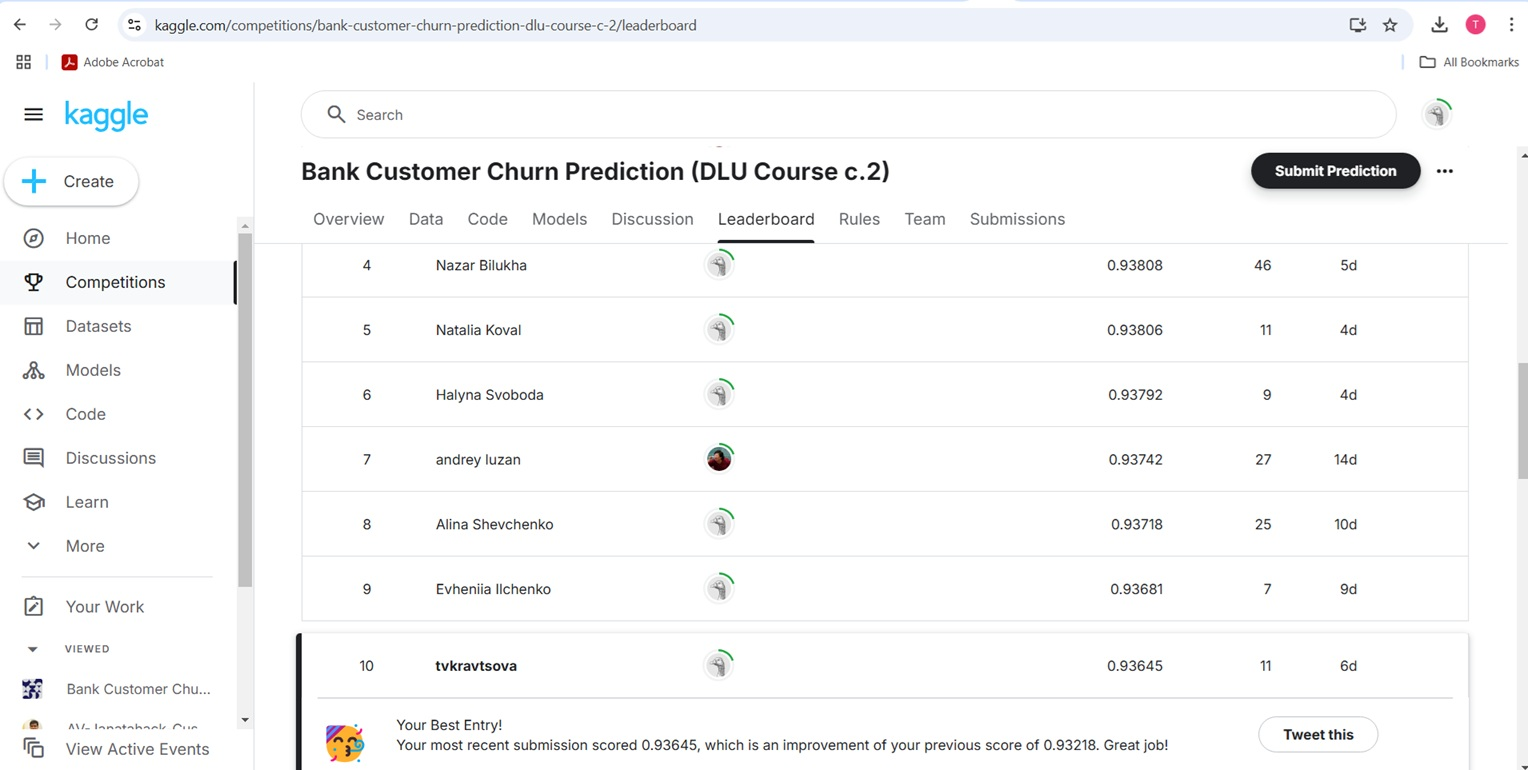

In [43]:
from IPython.display import display
from PIL import Image

image = Image.open('/content/screenshot_score.jpg')
display(image)